# Descriptive title that follows notebook filename

**Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only**

### General advice (delete this cell before submitting for review)

- When choosing a location for your analysis, **select an area that has data on both the `NCI` and `DEA Sandbox`** to allow your code to be run on both environments. 
For example, you can check this for Landsat using the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3/1990) (use the drop-down menu to view all products). 
As of September 2019, the `DEA Sandbox` has a single year of continental Landsat data for 2015-16, and the full 1987-onward time-series for three locations (Perth WA, Brisbane QLD, and western NSW).
- When writing in Markdown cells, start each sentence is on a **new line**.
This makes it easy to see changes through git commits.
- Use Australian English in markdown cells and code comments.
- Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.
- In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case, seperate words with spaces, and where possible re-use existing tags.
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.


### Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

### Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above, and a run-down of the tools/methods being demonstrated below.


### Technical details
* **Products used:** `product_name`, `product_name`, `product_name`
* **Analyses used:** NDWI water index, geomedian compositing, pixel drill
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook

## Getting started
Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

## Cowell Power Plant Project

Cowell is a coastal town on Franklin Harbor on the eastern side of the Eyre Peninsula, in South Australia 493 km by road from Adelaide. Franklin Harbor is a natural harbour with a channel to the sea just 100 metres wide.

This town is the major population centre of the District Council of Franklin Harbour, and the centre of an agricultural district, farming wheat and sheep. Fishing, and more recently, oyster farming has also been an important industry.

<img src="Cowell_Satellite.png" alt="drawing" width="400" align="left"/>

Cowell has recently attracted the attention of the South Australian government as a potential place to hold a promising new technology that allows getting energy from the tides. Franklin Harbour has a narrow channel to the sea through which every day millions of liters of water flow in and out as the tide changes. The people in the town are very excited with the idea of becoming a major producer of energy in SA and become the first tidal clean energy plant in Australia.

### Your task:

You are the lead engineer in charge of evaluating the viability of this project. The first question you have been asked is to get an estimate about how much energy this plant can generate. You have no previous experience working in tidal power plants but you have heards about a new Digital Earth Australia product that presents information of the tide extents as seen from satellite.

Using this dataset you can calculate how many liters of water go through the channel at each change of tide and then transform these numbers into KWatts using the efficiency values provided by the turbines manufacturer. 

One of your colleagues has given you the polygon delimiting Franklin Harbour cutting the channels at the place where the underwater turbines will be placed. Go to [geojson.io](http://geojson.io) to visualise the polygon. 

**Hint:** *Paste the contents delimited by the outer curly braces in the next cell in the right hand side panel of the website.*

In [3]:
poly = """{
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "LineString",
        "coordinates": [
          [
            136.91986083984375,
            -33.66549665763364
          ],
          [
            136.86492919921872,
            -33.71577279930021
          ],
          [
            136.84432983398438,
            -33.75403149821638
          ],
          [
            136.84398651123047,
            -33.798835278253975
          ],
          [
            136.86458587646484,
            -33.79312909288506
          ],
          [
            136.96208953857422,
            -33.745467600106174
          ],
          [
            136.96964263916016,
            -33.738615865848736
          ],
          [
            136.9552230834961,
            -33.73490428127589
          ],
          [
            136.98612213134766,
            -33.693780606387506
          ],
          [
            136.97650909423828,
            -33.667211101197545
          ],
          [
            136.91986083984375,
            -33.66549665763364
          ]
        ]
      }
    }"""

### Getting ready by loading some libraries 

Once you have verified the polygon data you decide to load your favorite Python libraries to start working on this project.

In [50]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import json
import sys
import xarray as xr

sys.path.append("../Scripts")
from dea_masking import mask

In [4]:
dc = datacube.Datacube(app="Tidal_powerplant")

### Selecting and loading the data

Getting Cowell's coordinates from Wikipedia you define an extension that covers the entire area around Franklin Harbour.

In [51]:
y = -33.683333
x = 136.916667

query = {'x': (x - .08, x + .1),
         'y': (y - .12, y + 0.03),         
         'crs': 'EPSG:4326'}

# Import ITEM v2.0 relative layer 
item_data = dc.load(product='item_v2', **query)

# Squeeze out the unnecessary temporal dimension:
item_data = item_data.squeeze(dim = 'time', drop = True)

# Filter out -6666 values present in this area
item_data['relative'] = item_data.relative.where(item_data.relative != -6666, 0)

item_data

<xarray.Dataset>
Dimensions:   (x: 690, y: 695)
Coordinates:
  * y         (y) float64 -3.681e+06 -3.681e+06 ... -3.698e+06 -3.698e+06
  * x         (x) float64 4.452e+05 4.453e+05 4.453e+05 ... 4.624e+05 4.625e+05
Data variables:
    relative  (y, x) int16 9 9 9 9 9 9 9 9 9 9 9 9 9 ... 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG:3577

### Plotting the ITEM Relative Extent data

Using your matplotlib skills you write a function to visualise the extensions exposed at different tide levels.

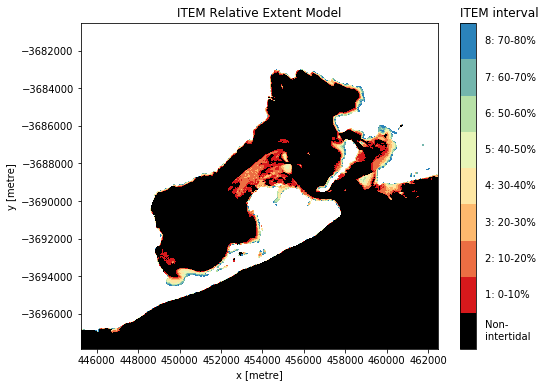

In [44]:
def plot_tides(ds):
    # Set up colour schemes and plot labels
    item_cs = ['black', '#d7191c', '#ec6e43', '#fdb96e', '#fee7a4', 
               '#e7f5b7', '#b7e1a7', '#74b6ad', '#2b83ba', 'white']
    labels = ['Non-\nintertidal', '1: 0-10%', '2: 10-20%', '3: 20-30%', 
              '4: 30-40%', '5: 40-50%', '6: 50-60%', '7: 60-70%', '8: 70-80%']

    # Plot ITEM Relative Extent Model
    item_plot = ds.plot(figsize=(8,6), levels=10, colors=item_cs, add_colorbar=False)
    plt.title('ITEM Relative Extent Model')

    # Add tidal interval percentages to colorbar
    cbar = plt.colorbar(item_plot)
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.set_title('ITEM interval', loc = 'left')

    for j, label in enumerate(labels):
        cbar.ax.text(1.5, (j + 0.5) / 9.0, label, ha='left', va='center', color='black')
    cbar.ax.get_yaxis().labelpad = 15
    
plot_tides(item_data.relative)

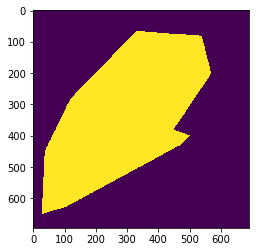

In [43]:
msk = mask(item_data.relative, poly)
plt.imshow(msk)

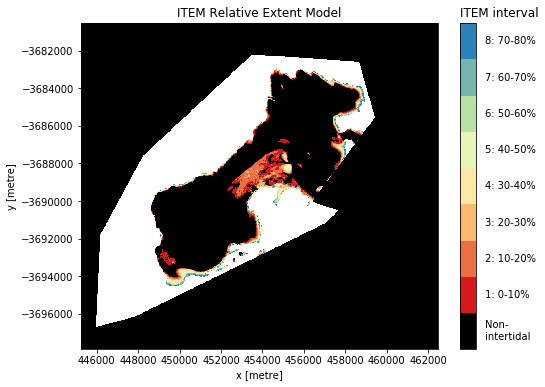

In [53]:
item_data['relative'] = item_data['relative'] * msk ### + (~msk * 9)

plot_tides(item_data.relative)

In [33]:
data = item_data.relative.data

area_covered = np.count_nonzero(~np.logical_or((data == 9), (data == 0)))
print(area_covered)
print(100.0 * np.count_nonzero(data == 1) / area_covered)
print(100.0 * np.count_nonzero(data == 2) / area_covered)
print(100.0 * np.count_nonzero(data == 3) / area_covered)
print(100.0 * np.count_nonzero(data == 4) / area_covered)
print(100.0 * np.count_nonzero(data == 5) / area_covered)
print(100.0 * np.count_nonzero(data == 6) / area_covered)
print(100.0 * np.count_nonzero(data == 7) / area_covered)
print(100.0 * np.count_nonzero(data == 8) / area_covered)

20380
31.516192345436703
26.82531894013739
14.735034347399411
11.310107948969579
5.363101079489696
3.999018645731109
3.846908734052993
2.4043179587831207


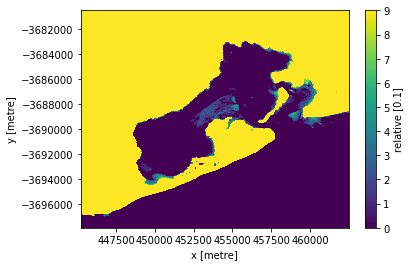

In [31]:
item_data.relative.plot()

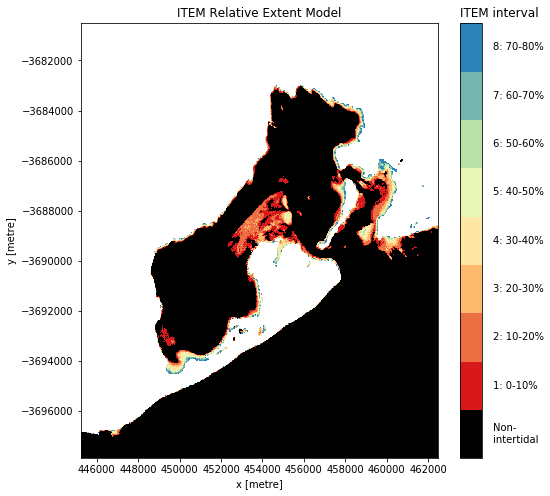

In [34]:
# Set up colour schemes and plot labels
item_cs = ['black', '#d7191c', '#ec6e43', '#fdb96e', '#fee7a4', 
           '#e7f5b7', '#b7e1a7', '#74b6ad', '#2b83ba', 'white']
labels = ['Non-\nintertidal', '1: 0-10%', '2: 10-20%', '3: 20-30%', 
          '4: 30-40%', '5: 40-50%', '6: 50-60%', '7: 60-70%', '8: 70-80%']

# Plot ITEM Relative Extent Model
item_plot = item_data.relative.plot(figsize=(8, 8), vmin=0, levels=10, colors=item_cs, add_colorbar=False)
plt.title('ITEM Relative Extent Model')

# Add tidal interval percentages to colorbar
cbar = plt.colorbar(item_plot)
cbar.ax.get_yaxis().set_ticks([])
cbar.ax.set_title('ITEM interval', loc = 'left')

for j, label in enumerate(labels):
    cbar.ax.text(1.5, (j + 0.5) / 9.0, label, ha='left', va='center', color='black')
cbar.ax.get_yaxis().labelpad = 15

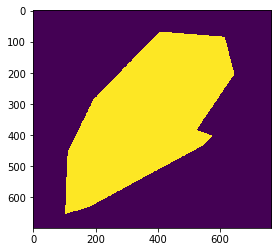

In [6]:
msk = mask(item_data.relative, poly)
plt.imshow(msk)

(698, 764)
(698, 764)
(533272,)
(533272,)


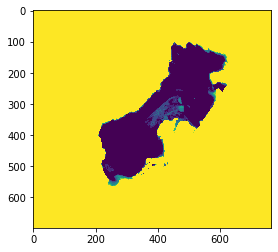

In [17]:
print(item_data.relative.data.shape)
print(msk.shape)

data = data.flatten()
print(data.shape)
data[~msk.flatten()] = 9
print(data.shape)


plt.imshow(data.reshape(msk.shape))

### Connect to the datacube
Give your datacube app a unique name that is consistent with the purpose of the notebook.

In [2]:
dc = datacube.Datacube(app="DEA_notebooks_template")

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:
* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


In [3]:
param_name_1 = "example_value"
param_name_2 = "example_value"

## Heading 1
Use headings to break up key steps/stages of the notebook.

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

In [4]:
# Use code comments for low-level documentation of code
a = 1

### Subheading 1
Use subheadings to break up steps within a single section.

In [5]:
# Use code comments for low-level documentation of code
b = 2

## Heading 2
Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

In [6]:
# Use code comments for low-level documentation of code
c = 3

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [7]:
print(datacube.__version__)

1.7+43.gc873f3ea


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)